# Recursive multi-step forecasting with exogenous variables
https://joaquinamatrodrigo.github.io/skforecast/0.3/guides/autoregresive-forecaster-exogenous.html

In [126]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from sklearn.linear_model import Ridge, Lasso

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [97]:
alaska = pd.read_csv(f'../data/alaska.csv')
alaska['week'] = pd.to_datetime(alaska['week'], format = '%Y-%m-%d')
alaska.set_index('week', inplace=True)
alaska.head()

state  depression  anxiety  addiction  counselling  \
week                                                              
2017-12-31  Alaska          28       46         24           37   
2018-01-07  Alaska          37       45         25           65   
2018-01-14  Alaska          10       46         16           53   
2018-01-21  Alaska          33       41         10           35   
2018-01-28  Alaska          32       24          0           40   

            mental_health  stay_at_home  mask_mandate  gatherings_banned  \
week                                                                       
2017-12-31              0             0             0                  0   
2018-01-07             37             0             0                  0   
2018-01-14             30             0             0                  0   
2018-01-21             14             0             0                  0   
2018-01-28              0             0             0                  0   

            business_closures  travel_restrictions  
week                                                
2017-12-31                  0                    0  
2018-01-07                  0                    0  
2018-01-14                  0                    0  
2018-01-21                  0                    0  
2018-01-28                  0                    0

In [98]:
alaska = alaska.asfreq('W')

In [99]:
alaska.isnull().sum()

state                  0
depression             0
anxiety                0
addiction              0
counselling            0
mental_health          0
stay_at_home           0
mask_mandate           0
gatherings_banned      0
business_closures      0
travel_restrictions    0
dtype: int64

In [100]:
alaska.head()

state  depression  anxiety  addiction  counselling  \
week                                                              
2017-12-31  Alaska          28       46         24           37   
2018-01-07  Alaska          37       45         25           65   
2018-01-14  Alaska          10       46         16           53   
2018-01-21  Alaska          33       41         10           35   
2018-01-28  Alaska          32       24          0           40   

            mental_health  stay_at_home  mask_mandate  gatherings_banned  \
week                                                                       
2017-12-31              0             0             0                  0   
2018-01-07             37             0             0                  0   
2018-01-14             30             0             0                  0   
2018-01-21             14             0             0                  0   
2018-01-28              0             0             0                  0   

            business_closures  travel_restrictions  
week                                                
2017-12-31                  0                    0  
2018-01-07                  0                    0  
2018-01-14                  0                    0  
2018-01-21                  0                    0  
2018-01-28                  0                    0

In [101]:
# Split train-test
# ==============================================================================
steps = 36
data_train = alaska.iloc[:-steps, :]
data_test  = alaska.iloc[-steps:, :]

In [103]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = GradientBoostingRegressor(),
                    lags      = 15
                )

forecaster.fit(
    y    = data_train['anxiety'],
    exog = data_train[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
)

forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions'] 
Training range: [Timestamp('2017-12-31 00:00:00'), Timestamp('2022-04-24 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol':

In [104]:
predictions = forecaster.predict(
                steps = steps,
                exog = data_test[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
               )
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(3)

week
2022-05-01    43.993078
2022-05-08    60.091431
2022-05-15    42.266052
Freq: W-SUN, Name: pred, dtype: float64

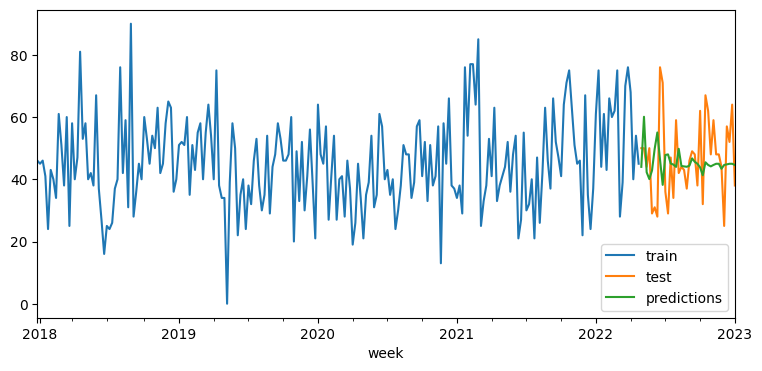

In [105]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train['anxiety'].plot(ax=ax, label='train')
data_test['anxiety'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [107]:
error_mse = mean_squared_error(
                y_true = data_test['anxiety'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 191.73826025310873


In [108]:
forecaster.get_feature_importance()

feature  importance
0                 lag_1    0.106545
1                 lag_2    0.079205
2                 lag_3    0.046388
3                 lag_4    0.043837
4                 lag_5    0.103329
5                 lag_6    0.086065
6                 lag_7    0.046381
7                 lag_8    0.050523
8                 lag_9    0.074940
9                lag_10    0.074418
10               lag_11    0.060905
11               lag_12    0.028475
12               lag_13    0.026570
13               lag_14    0.075381
14               lag_15    0.075678
15         stay_at_home    0.000000
16         mask_mandate    0.000000
17    gatherings_banned    0.011114
18    business_closures    0.009221
19  travel_restrictions    0.001024

# California - Anxiety  - Ridge

In [154]:
california = pd.read_csv(f'../data/california.csv')
california['week'] = pd.to_datetime(california['week'], format = '%Y-%m-%d')


california = california[california['week'] < '2020-10-01']
california.set_index('week', inplace=True)
california.tail()

state  depression  anxiety  addiction  counselling  \
week                                                                  
2020-08-30  California          64       90         22           32   
2020-09-06  California          65       91         22           26   
2020-09-13  California          67       89         22           27   
2020-09-20  California          71       97         25           30   
2020-09-27  California          65       87         24           27   

            mental_health  stay_at_home  mask_mandate  gatherings_banned  \
week                                                                       
2020-08-30             46             0             1                  1   
2020-09-06             46             0             1                  1   
2020-09-13             49             0             1                  1   
2020-09-20             49             0             1                  1   
2020-09-27             47             0             1                  1   

            business_closures  travel_restrictions  
week                                                
2020-08-30                  1                    0  
2020-09-06                  1                    0  
2020-09-13                  1                    0  
2020-09-20                  1                    0  
2020-09-27                  1                    0

In [155]:
california = california.asfreq('W')
alaska.isnull().sum()

state                  0
depression             0
anxiety                0
addiction              0
counselling            0
mental_health          0
stay_at_home           0
mask_mandate           0
gatherings_banned      0
business_closures      0
travel_restrictions    0
dtype: int64

In [156]:
california.shape

(144, 11)

In [157]:
# Split train-test
# ==============================================================================
steps = 15
data_train = california.iloc[:-steps, :]
data_test  = california.iloc[-steps:, :]

In [158]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(),
                    lags      = 15
                )

forecaster.fit(
    y    = data_train['anxiety'],
    exog = data_train[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
)

forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions'] 
Training range: [Timestamp('2017-12-31 00:00:00'), Timestamp('2020-06-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-01-28 08:50:54 
Last fit date: 2023-01-28 08:50:54 
Skforecast version: 0.6.0 
Python version: 3.7.16 

In [159]:
predictions = forecaster.predict(
                steps = steps,
                exog = data_test[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
               )
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(3)

week
2020-06-21    83.610749
2020-06-28    80.026077
2020-07-05    78.844320
Freq: W-SUN, Name: pred, dtype: float64

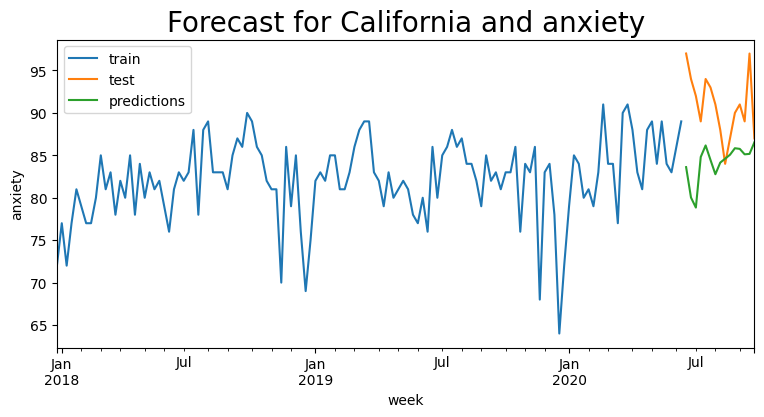

In [168]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train['anxiety'].plot(ax=ax, label='train')
data_test['anxiety'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
ax.set_title('Forecast for California and anxiety', size = 20)
ax.set_ylabel('anxiety');

In [127]:
error_mse = mean_squared_error(
                y_true = data_test['anxiety'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 65.74166488161913


In [128]:
forecaster.get_feature_importance()

feature  importance
0                 lag_1    0.261741
1                 lag_2    0.071679
2                 lag_3   -0.161966
3                 lag_4    0.201097
4                 lag_5    0.041572
5                 lag_6    0.012730
6                 lag_7   -0.061499
7                 lag_8    0.032677
8                 lag_9   -0.072849
9                lag_10   -0.106063
10               lag_11    0.028374
11               lag_12   -0.049485
12               lag_13   -0.146886
13               lag_14   -0.076599
14               lag_15    0.066312
15         stay_at_home   -0.698565
16         mask_mandate    0.000000
17    gatherings_banned    1.442319
18    business_closures    1.442319
19  travel_restrictions    0.000000

# California - Anxiety - Lasso

Since the ForecasterAutoreg object uses Scikit-learn models, the importance of predictors can be accessed once trained. When the regressor used is a LinearRegression(), Lasso() or Ridge(), the coefficients of the model reflect their importance. In GradientBoostingRegressor() or RandomForestRegressor() regressors, the importance of predictors is based on impurity.

In [170]:
def forecast_state_search(state, period, steps, search, regressor, lags):
    '''
    Read the data and forecast for chosen search term with chosen regressor
    Input:
    state - lowercase name of the state 
    period - last date for the data, string, format Y-m-d, maxinmum 2023-01-01
    steps - int, test split (number of weeks for test data and predicting)
    regressor - name of regressor for forecasting model 
    lags - int, on what time perion to forecast
    
    Output:
    State and Search term
    Forecaster output
    First 3 predictions
    Predictions vs actual plot
    MSE 
    Feature importances
    
    Return:
    Forecaster
    '''
    # Print state and search
    print(f'Forecast for {state} and {search} untill {period} \n' )
    
    # Read the data for the state
    df = pd.read_csv(f'../data/{state}.csv')
    df['week'] = pd.to_datetime(df['week'], format = '%Y-%m-%d')
    df = df[df['week'] < period]
    df.set_index('week', inplace=True)
    
    # Change to frequency
    df = df.asfreq('W')
    
    # Split the data to train-test
    steps = steps
    data_train = df.iloc[:-steps, :]
    data_test  = df.iloc[-steps:, :]
    
    # Create and fit forecaster
    forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = lags
                )

    forecaster.fit(
        y    = data_train[search],
        exog = data_train[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
    )

    #print(forecaster)
    
    # predict
    predictions = forecaster.predict(
                steps = steps,
                exog = data_test[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
               )
    
    # Add datetime index to predictions
    predictions = pd.Series(data=predictions, index=data_test.index)
    print('First three predictions')
    print(predictions.head(3))
    print('\n')
    
    # Plot predictions vs actual
    fig, ax=plt.subplots(figsize=(9, 4))
    data_train[search].plot(ax=ax, label='train')
    data_test[search].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()
    ax.set_title(f'Forecast for {state} and {search}', size = 20)
    ax.set_ylabel(f'{search}', size = 20)
    ax.set_xlabel('Week', size = 20);
    plt.plot()
    
    # Calculate MSE
    error_mse = mean_squared_error(
                y_true = data_test[search],
                y_pred = predictions
            )
    print(f"Test error (mse): {error_mse} \n")
    
    # Feature importances
    if ('GradientBoostingRegressor' in str(regressor)) | ('RandomForestRegressor' in str(regressor)):
        print('The importance of predictors is based on impurity.')
        print(forecaster.get_feature_importance())
    else:
        print('The coefficients of the model reflect their importance')
        print(forecaster.get_feature_importance())
        
    return forecaster

Forecast for california and anxiety untill 2020-10-01 

First three predictions
week
2020-06-21    83.545901
2020-06-28    81.058436
2020-07-05    80.949309
Freq: W-SUN, Name: pred, dtype: float64


Test error (mse): 97.82860790832875 

The coefficients of the model reflect their importance
                feature  importance
0                 lag_1    0.251863
1                 lag_2    0.024568
2                 lag_3   -0.052177
3                 lag_4    0.175931
4                 lag_5    0.000000
5                 lag_6    0.000000
6                 lag_7   -0.000000
7                 lag_8   -0.000000
8                 lag_9   -0.021517
9                lag_10   -0.023136
10               lag_11   -0.000000
11               lag_12   -0.026643
12               lag_13   -0.128131
13               lag_14   -0.054036
14               lag_15    0.000000
15         stay_at_home    0.000000
16         mask_mandate    0.000000
17    gatherings_banned    0.000000
18    business_closures 

ForecasterAutoreg 
Regressor: Lasso() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions'] 
Training range: [Timestamp('2017-12-31 00:00:00'), Timestamp('2020-06-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
Creation date: 2023-01-28 08:55:49 
Last fit date: 2023-01-28 08:55:49 
Skforecast version: 0.6.0 
Python version: 3.7.16 

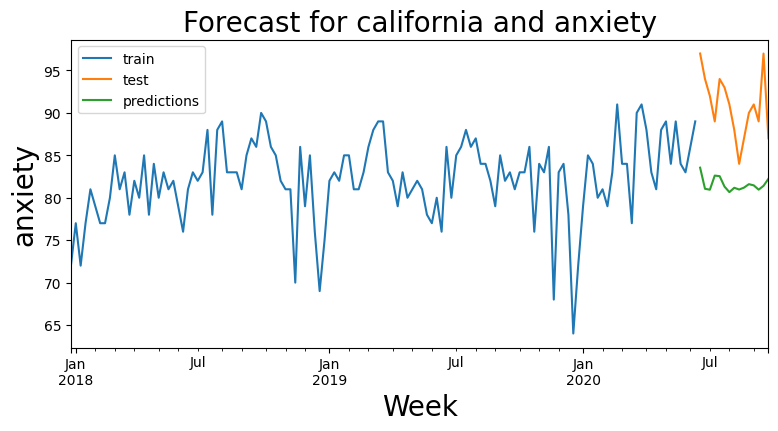

In [171]:
forecast_state_search(state='california', period='2020-10-01', steps=15, search='anxiety', regressor=Lasso(), lags=15)

Forecast for california and anxiety untill 2020-10-01 

First three predictions
week
2020-06-21    85.860019
2020-06-28    85.604084
2020-07-05    83.419048
Freq: W-SUN, Name: pred, dtype: float64


Test error (mse): 77.78550416093795 

The importance of predictors is based on impurity.
                feature  importance
0                 lag_1    0.091221
1                 lag_2    0.068311
2                 lag_3    0.042145
3                 lag_4    0.203883
4                 lag_5    0.149620
5                 lag_6    0.030027
6                 lag_7    0.063296
7                 lag_8    0.028432
8                 lag_9    0.015181
9                lag_10    0.033901
10               lag_11    0.023743
11               lag_12    0.067850
12               lag_13    0.053535
13               lag_14    0.062703
14               lag_15    0.022354
15         stay_at_home    0.000000
16         mask_mandate    0.000000
17    gatherings_banned    0.018013
18    business_closures    0

ForecasterAutoreg 
Regressor: GradientBoostingRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions'] 
Training range: [Timestamp('2017-12-31 00:00:00'), Timestamp('2020-06-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol':

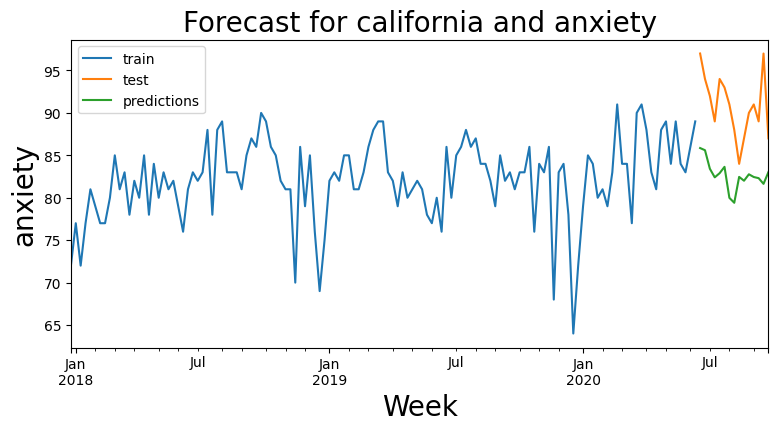

In [172]:
forecast_state_search(state='california', period='2020-10-01', steps=15, search='anxiety', regressor=GradientBoostingRegressor(), lags=15)

Forecast for california and depression untill 2020-10-01 

First three predictions
week
2020-06-21    65.373366
2020-06-28    62.577259
2020-07-05    62.039439
Freq: W-SUN, Name: pred, dtype: float64


Test error (mse): 46.97064811216505 

The coefficients of the model reflect their importance
                feature  importance
0                 lag_1    0.714952
1                 lag_2    0.062707
2                 lag_3   -0.249986
3                 lag_4    0.385913
4                 lag_5   -0.032330
5                 lag_6   -0.168938
6                 lag_7    0.181571
7                 lag_8    0.012447
8                 lag_9   -0.178549
9                lag_10    0.091395
10               lag_11   -0.062425
11               lag_12   -0.007828
12               lag_13   -0.009082
13               lag_14   -0.100596
14               lag_15    0.060297
15         stay_at_home   -0.680165
16         mask_mandate    0.000000
17    gatherings_banned    0.136221
18    business_closur

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions'] 
Training range: [Timestamp('2017-12-31 00:00:00'), Timestamp('2020-06-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-01-28 08:56:08 
Last fit date: 2023-01-28 08:56:08 
Skforecast version: 0.6.0 
Python version: 3.7.16 

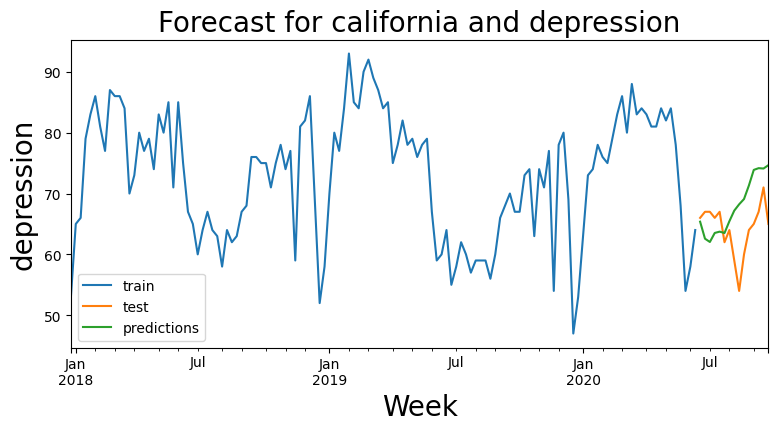

In [173]:
forecast_state_search(state='california', period='2020-10-01', steps=15, search='depression', regressor=Ridge(), lags=15)

Forecast for alaska and depression untill 2020-10-01 

First three predictions
week
2020-06-21    25.314207
2020-06-28    18.652473
2020-07-05    26.332315
Freq: W-SUN, Name: pred, dtype: float64


Test error (mse): 385.46889233115377 

The coefficients of the model reflect their importance
                feature  importance
0                 lag_1   -0.011392
1                 lag_2   -0.017250
2                 lag_3    0.150498
3                 lag_4    0.061965
4                 lag_5    0.099647
5                 lag_6    0.039462
6                 lag_7    0.008214
7                 lag_8    0.012133
8                 lag_9    0.026697
9                lag_10    0.060503
10               lag_11   -0.068782
11               lag_12   -0.033148
12               lag_13    0.038321
13               lag_14    0.009283
14               lag_15   -0.062882
15         stay_at_home    6.623693
16         mask_mandate    0.000000
17    gatherings_banned    1.104040
18    business_closures 

C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test error (mse): 514.6388710429724 

The coefficients of the model reflect their importance
                feature  importance
0                 lag_1    0.164540
1                 lag_2   -0.124930
2                 lag_3   -0.058950
3                 lag_4    0.273673
4                 lag_5   -0.011385
5                 lag_6    0.278625
6                 lag_7   -0.204910
7                 lag_8    0.045973
8                 lag_9   -0.039724
9                lag_10   -0.169265
10               lag_11    0.020579
11               lag_12   -0.036749
12               lag_13    0.038558
13               lag_14   -0.006887
14               lag_15    0.130102
15         stay_at_home    6.589844
16         mask_mandate    0.442645
17    gatherings_banned    0.442645
18    business_closures    0.442645
19  travel_restrictions   -6.129562
Forecast for hawaii and addiction untill 2020-10-01 

First three predictions
week
2020-06-21    21.194685
2020-06-28    23.333068
2020-07-05    16.882

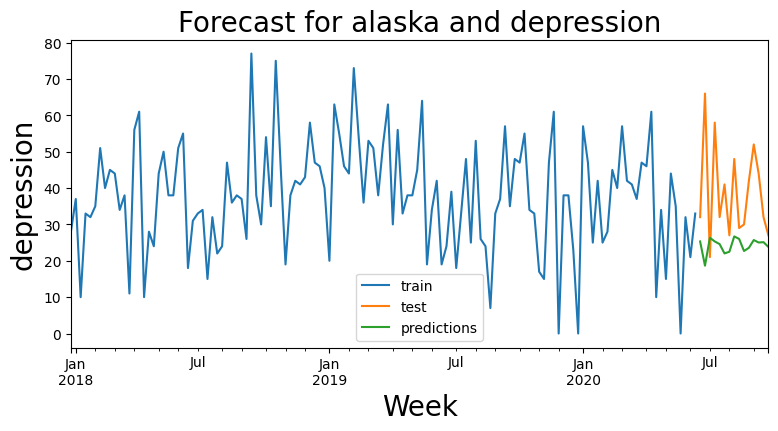

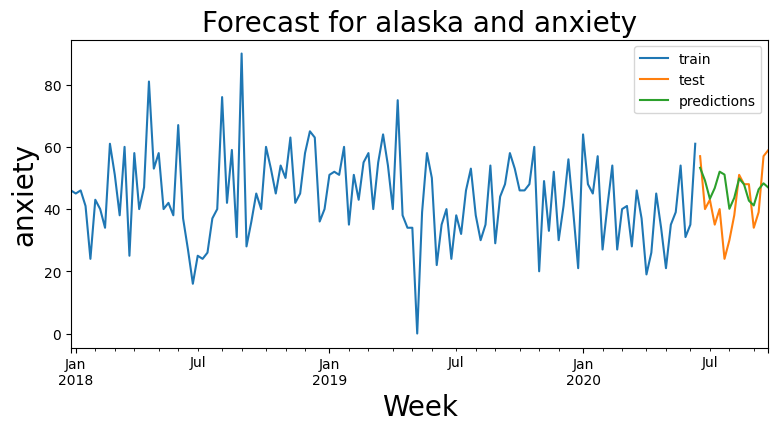

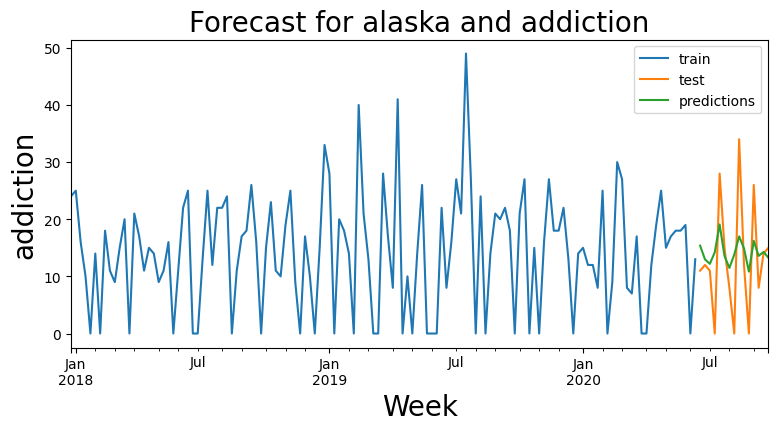

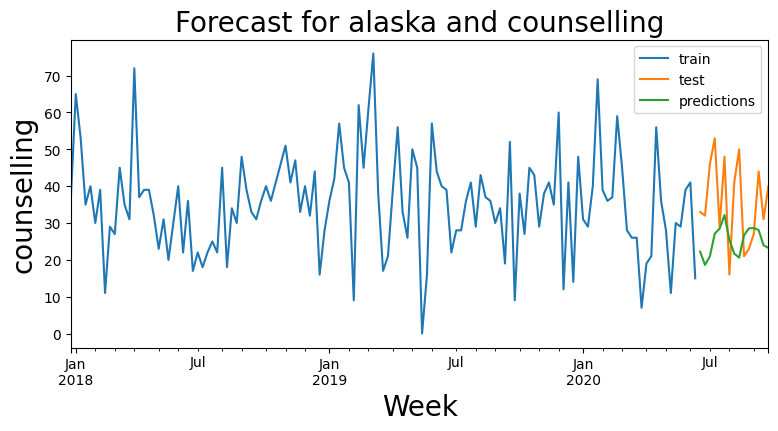

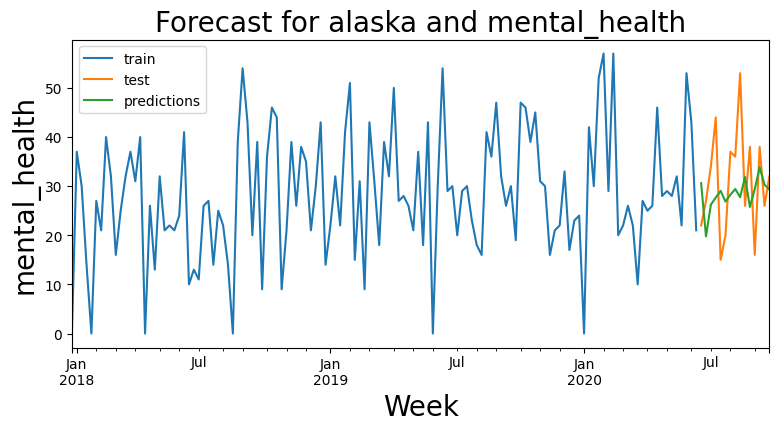

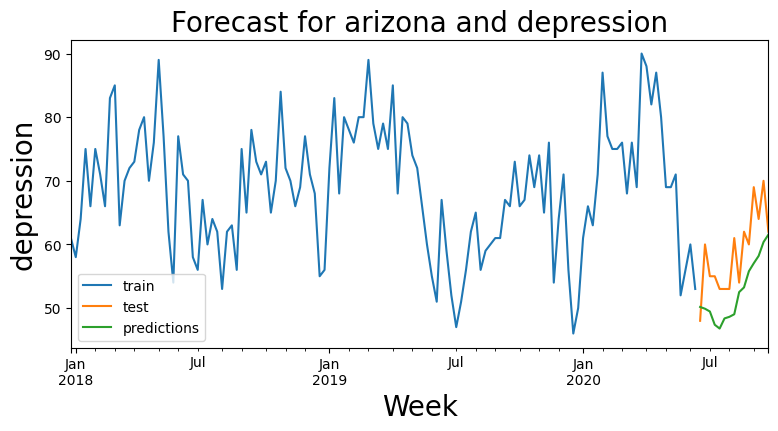

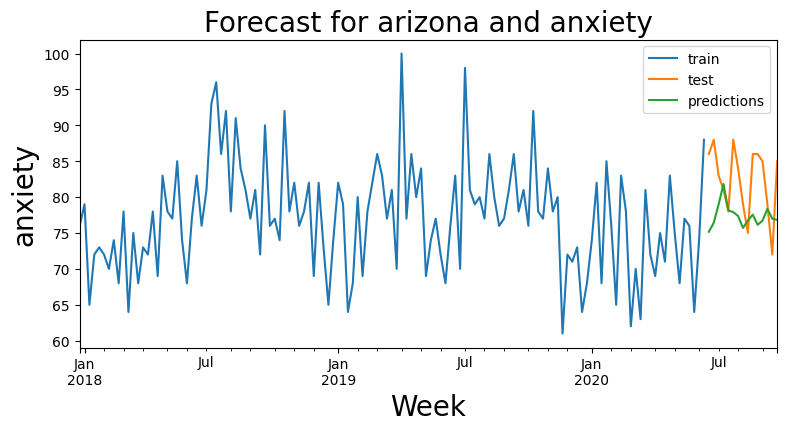

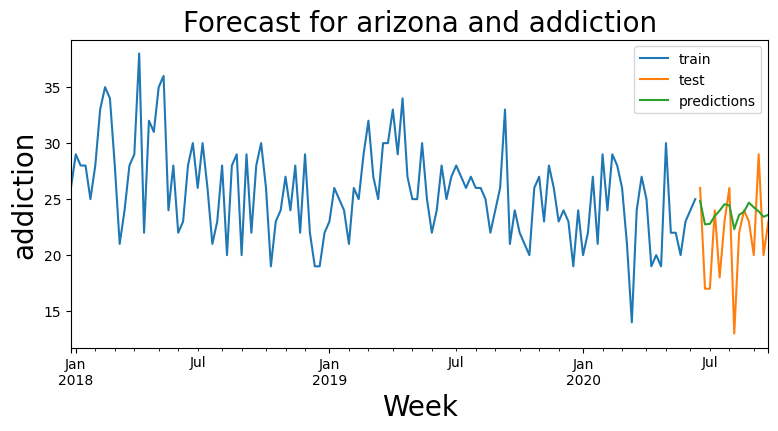

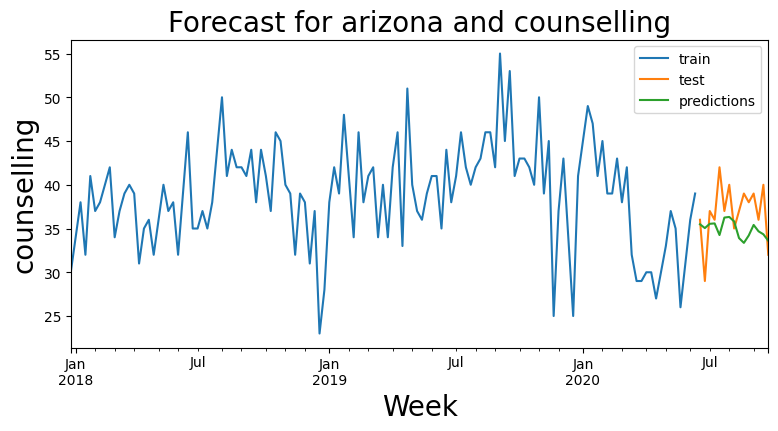

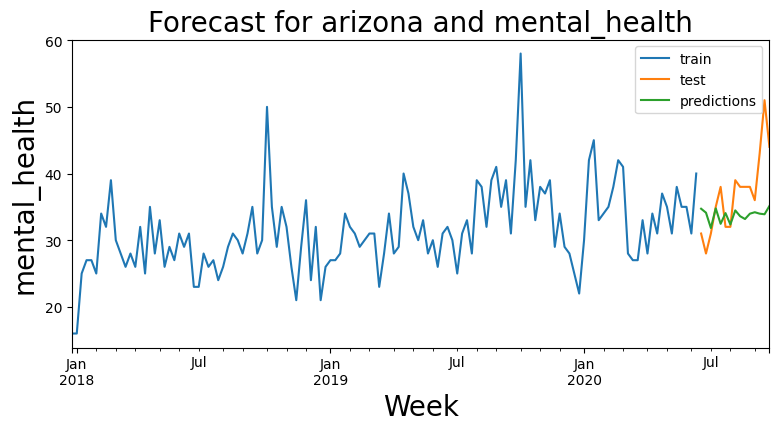

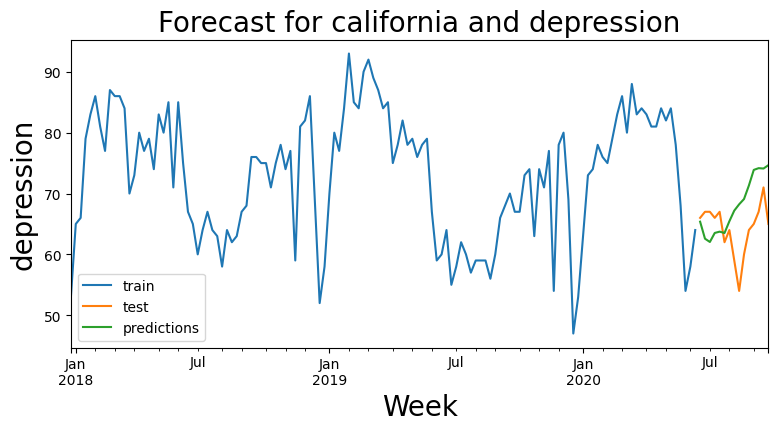

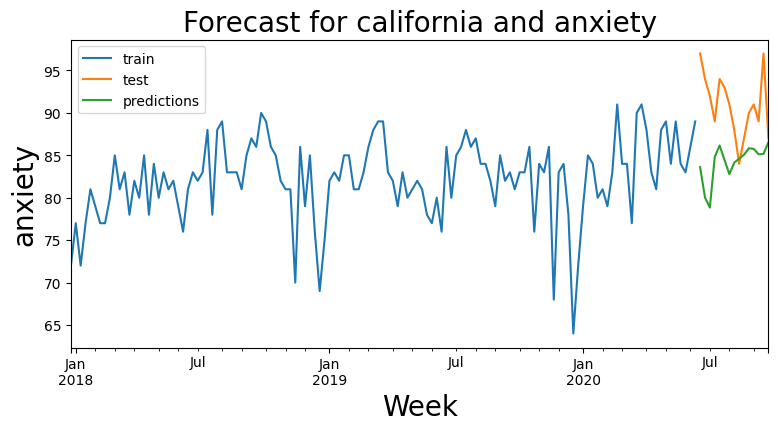

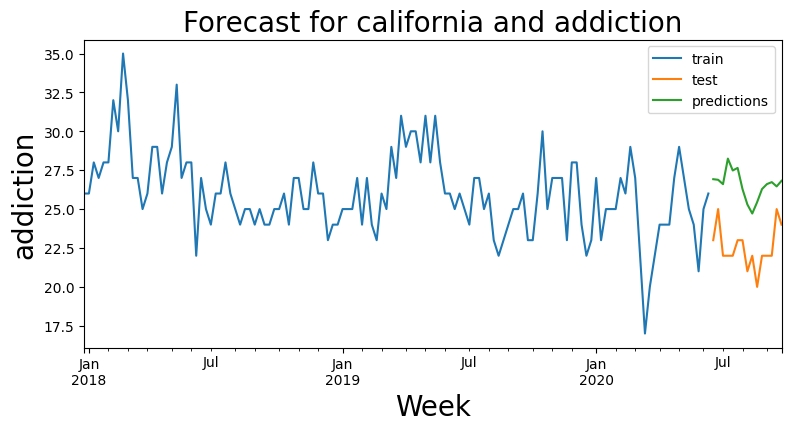

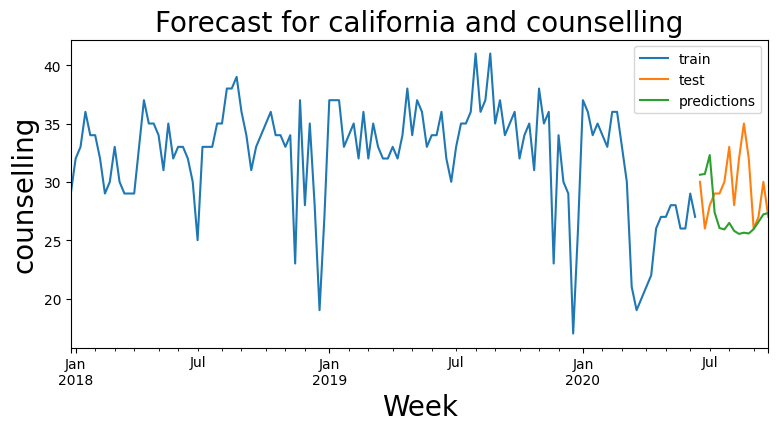

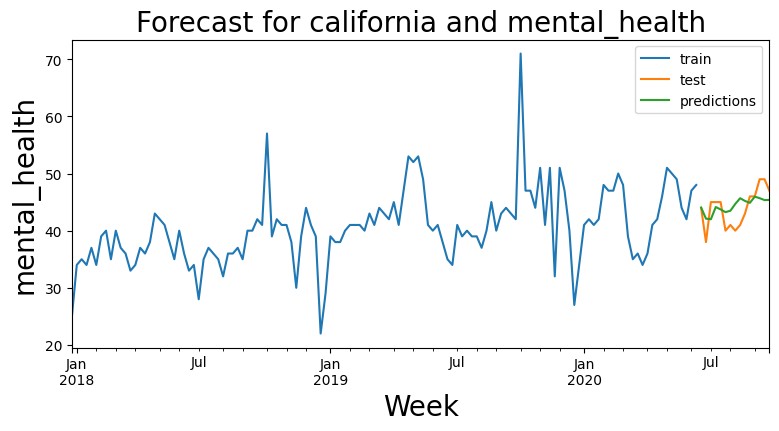

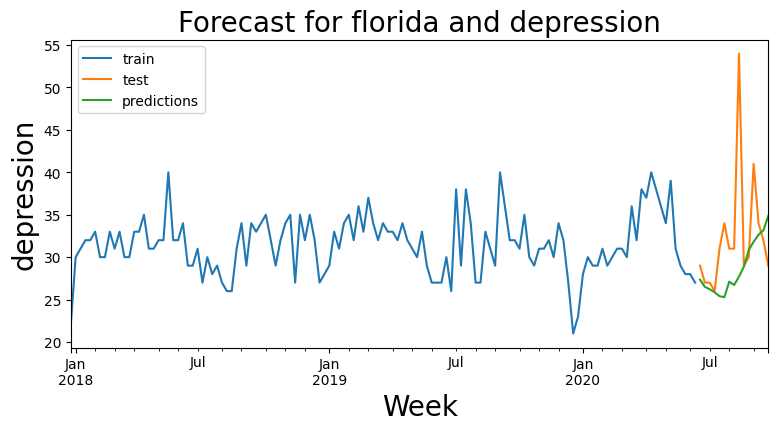

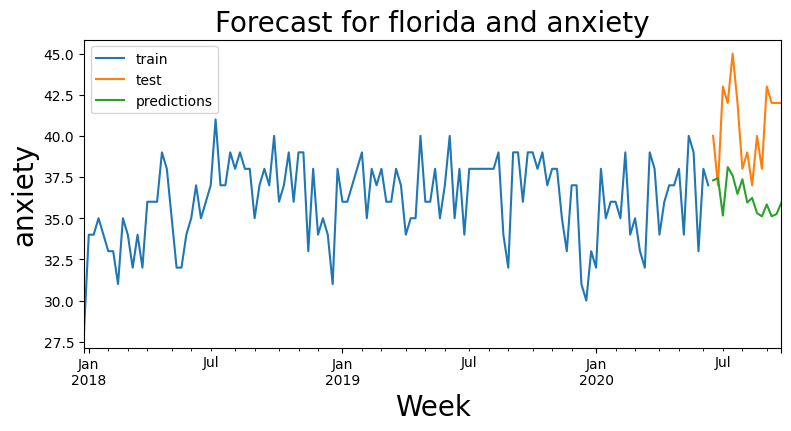

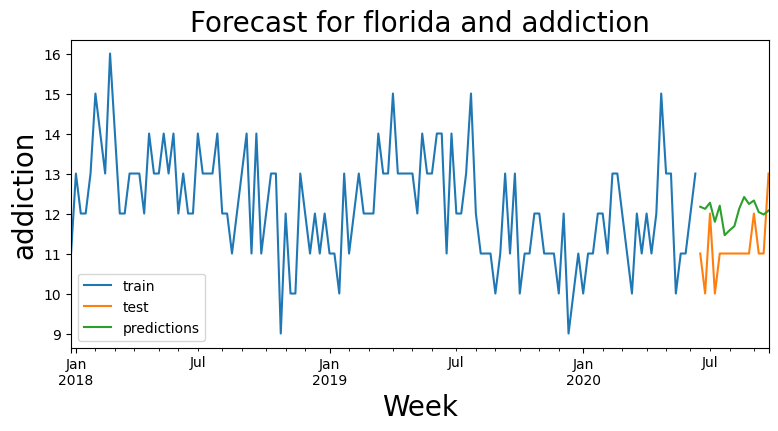

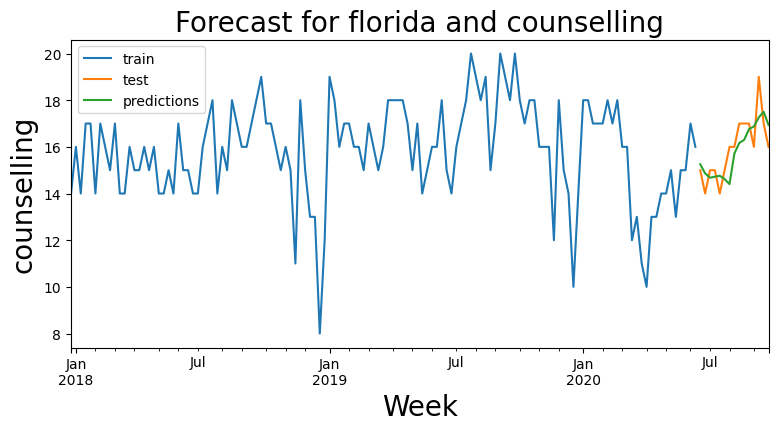

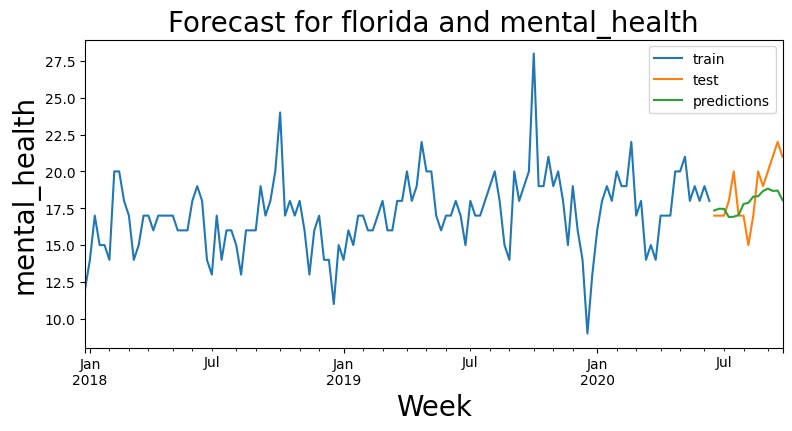

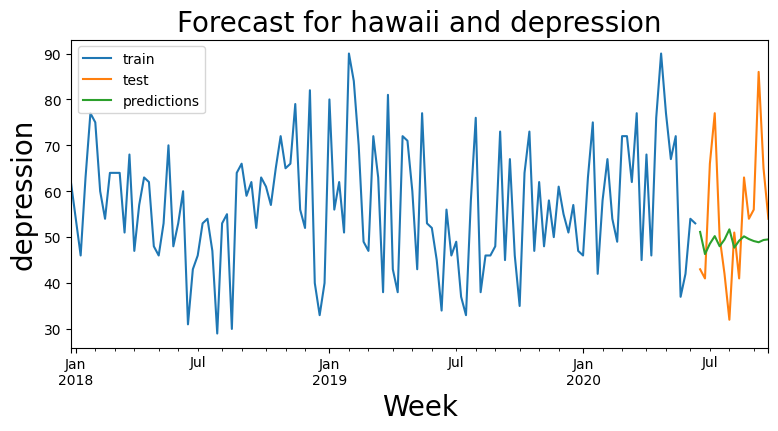

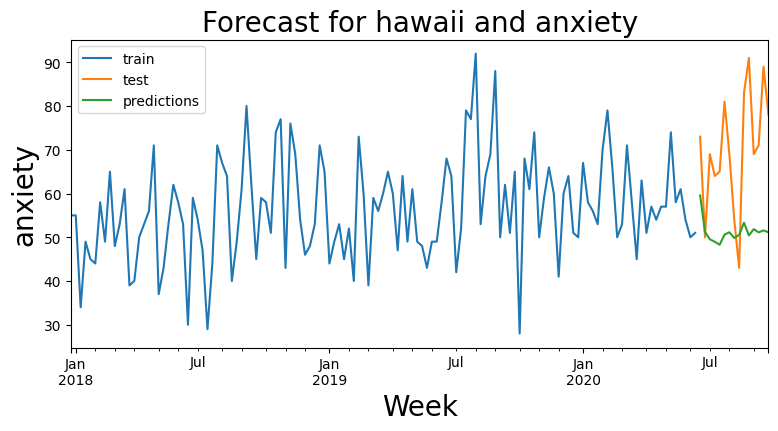

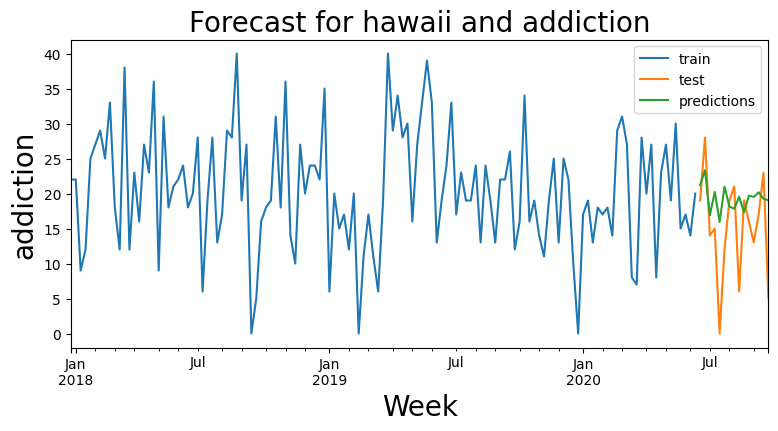

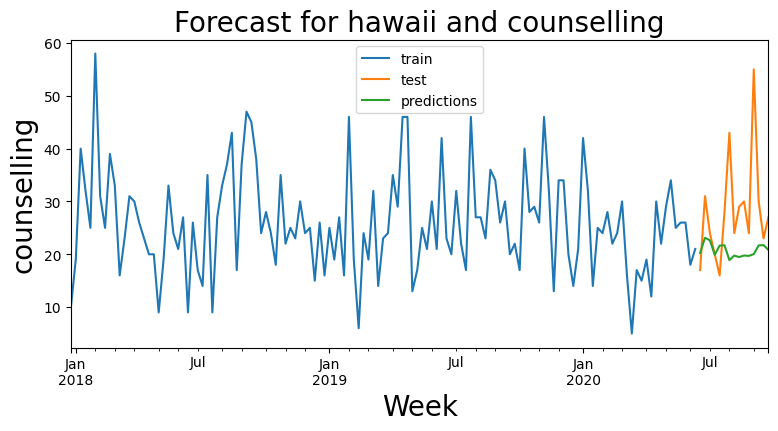

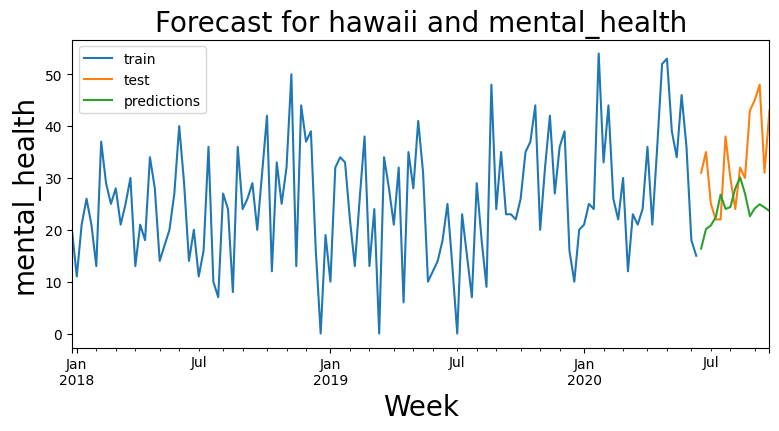

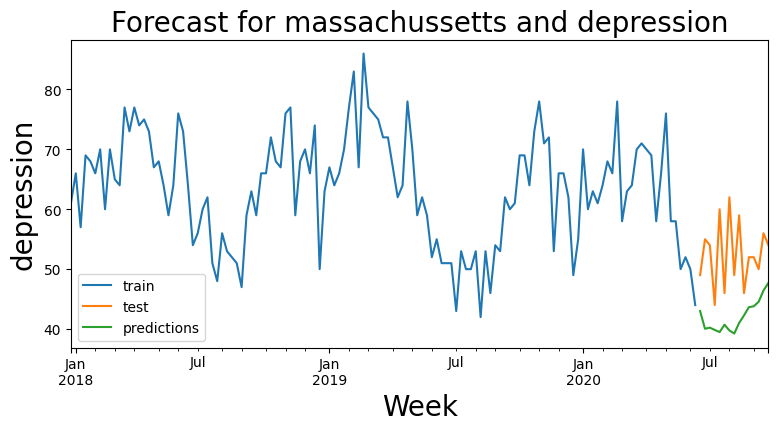

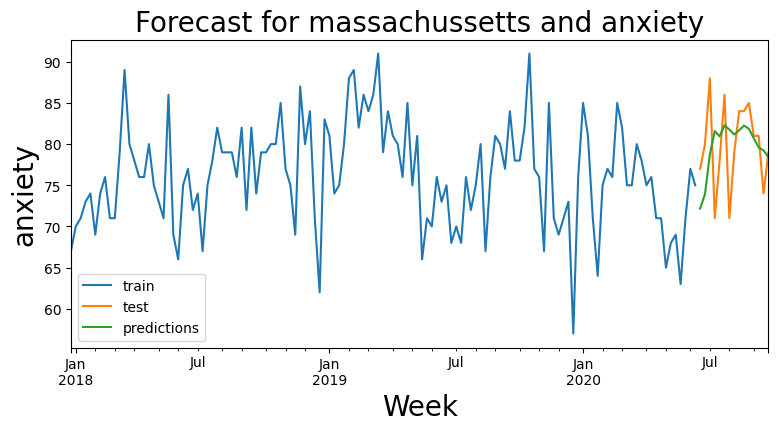

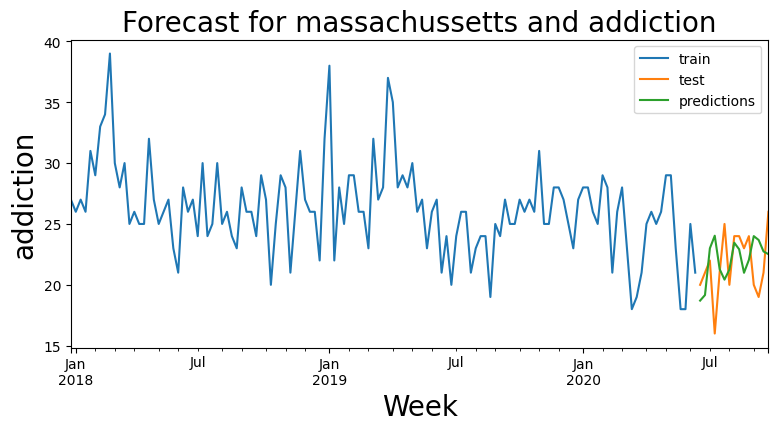

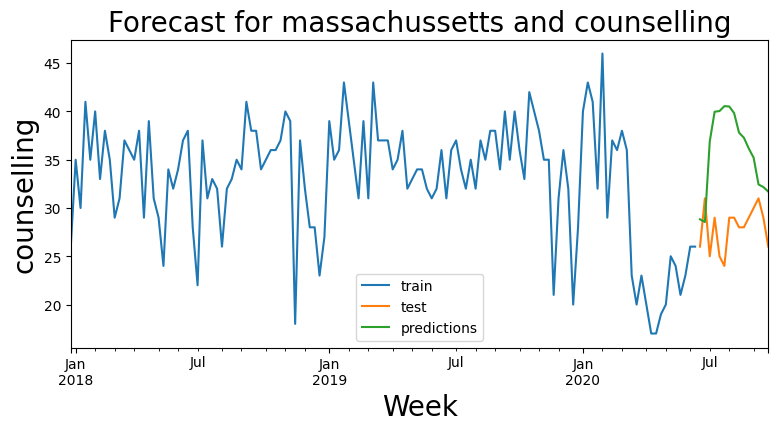

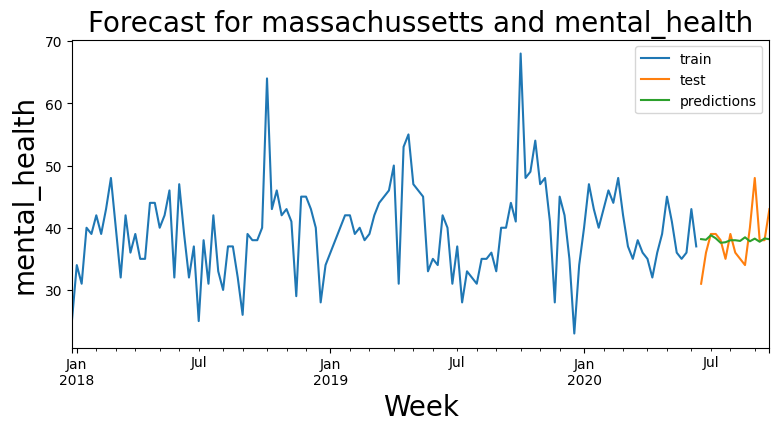

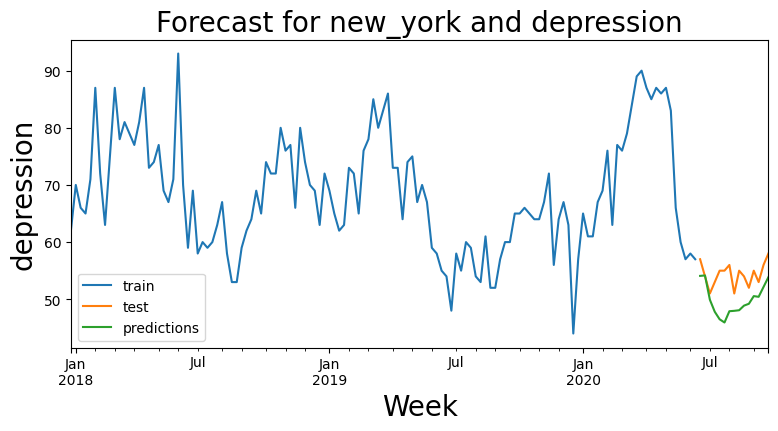

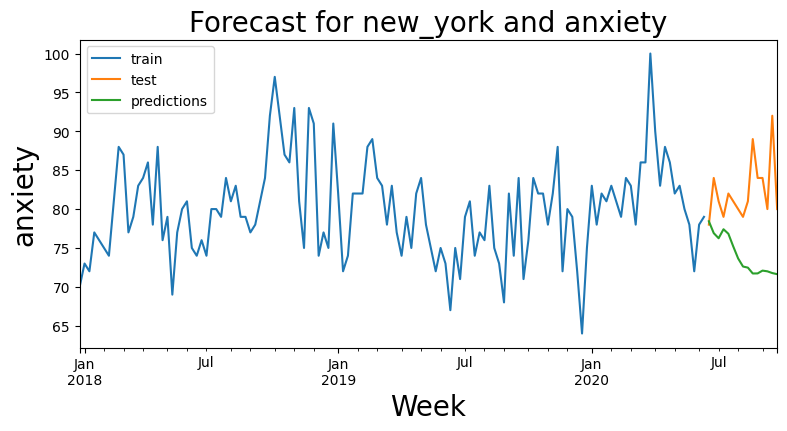

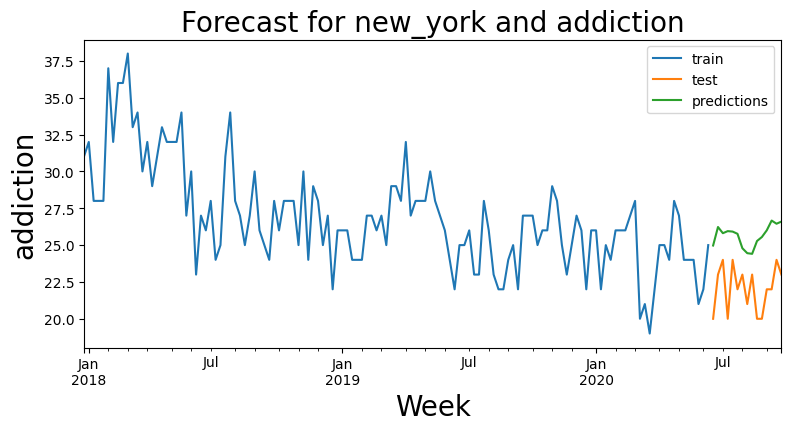

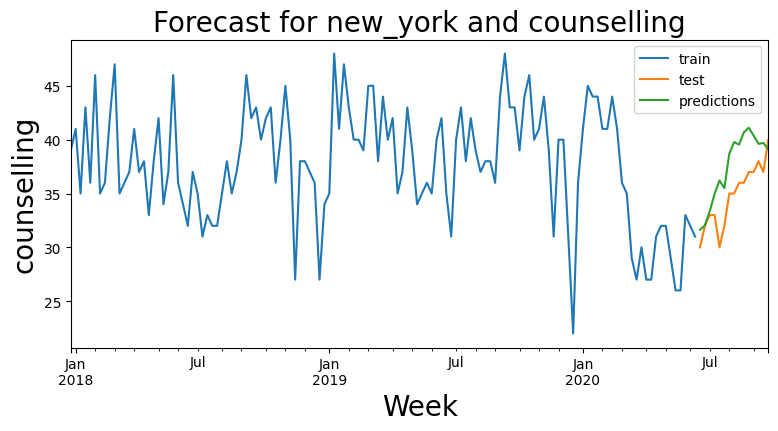

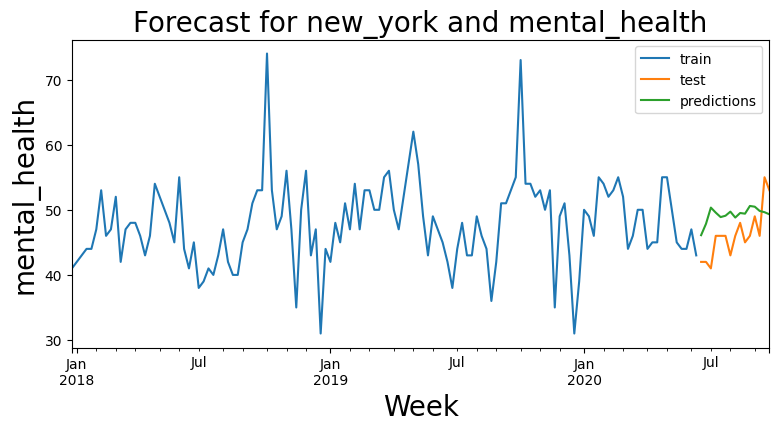

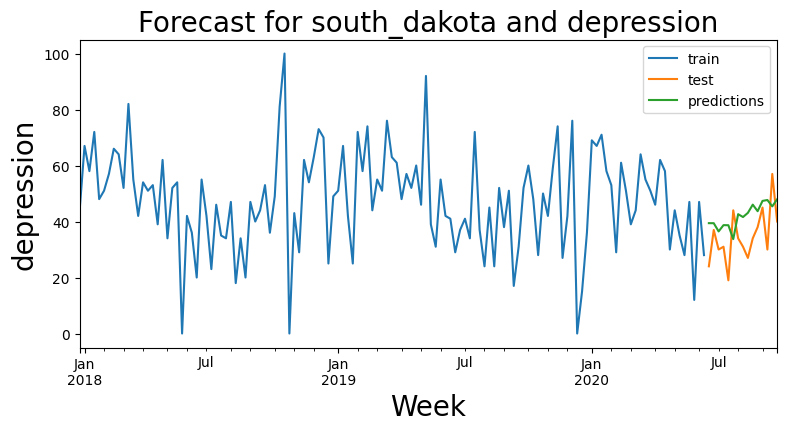

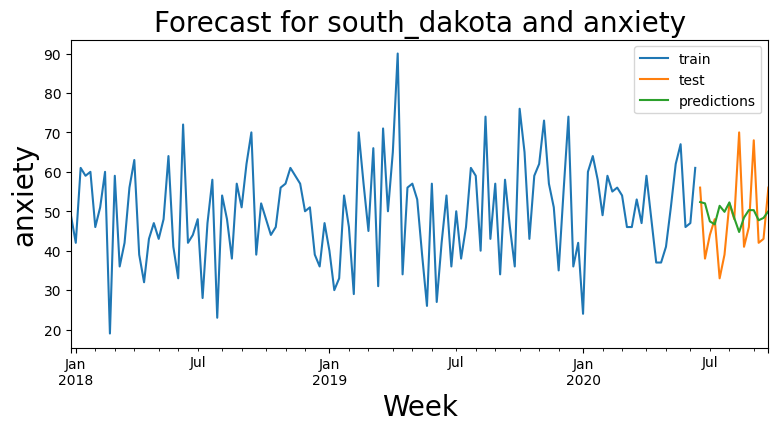

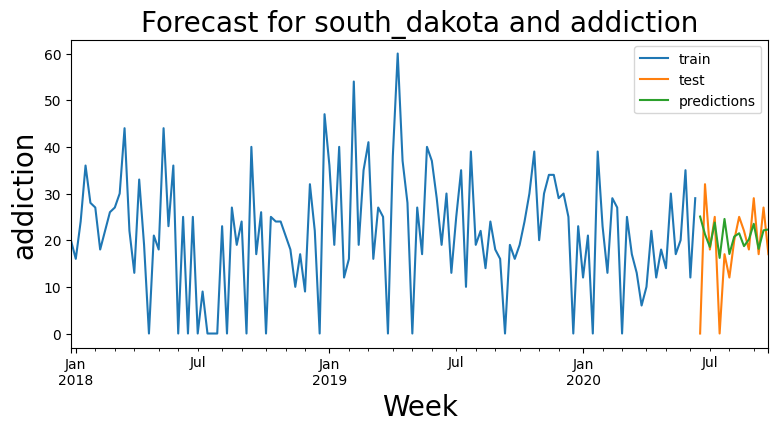

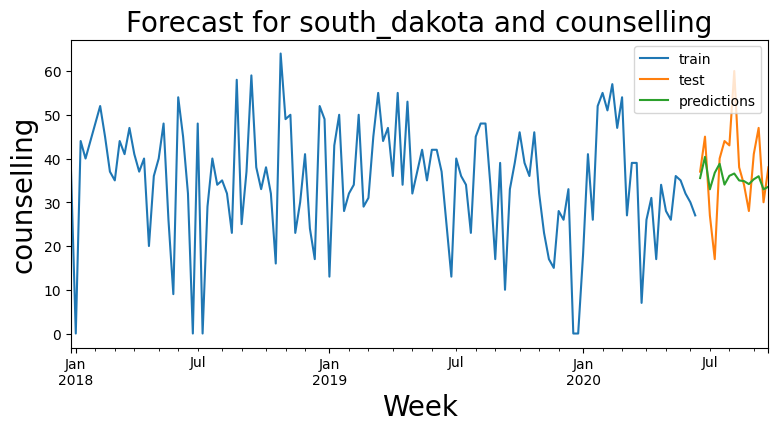

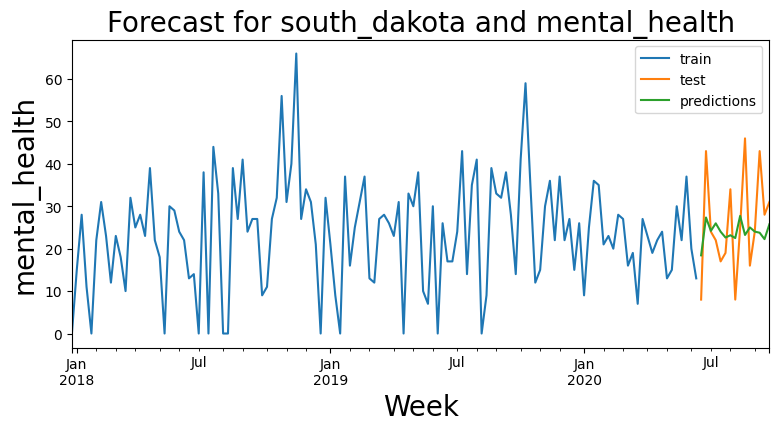

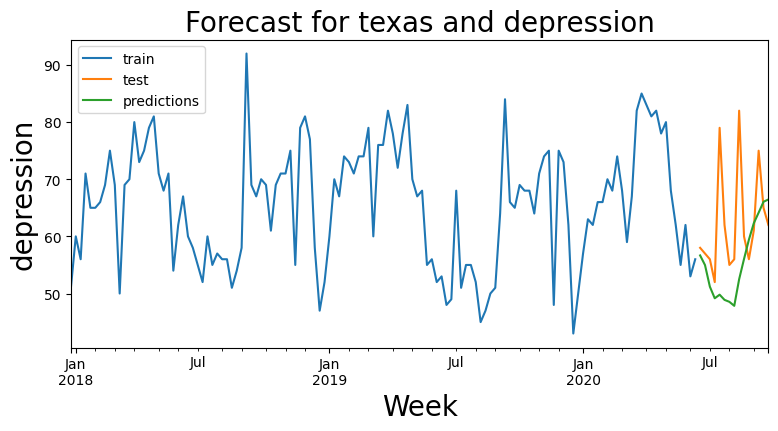

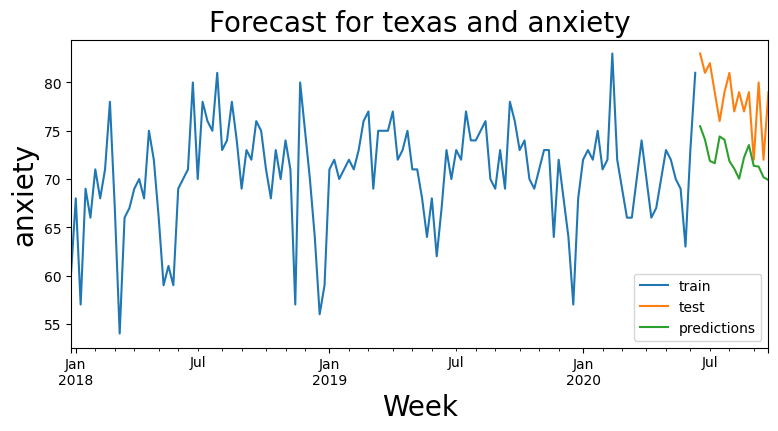

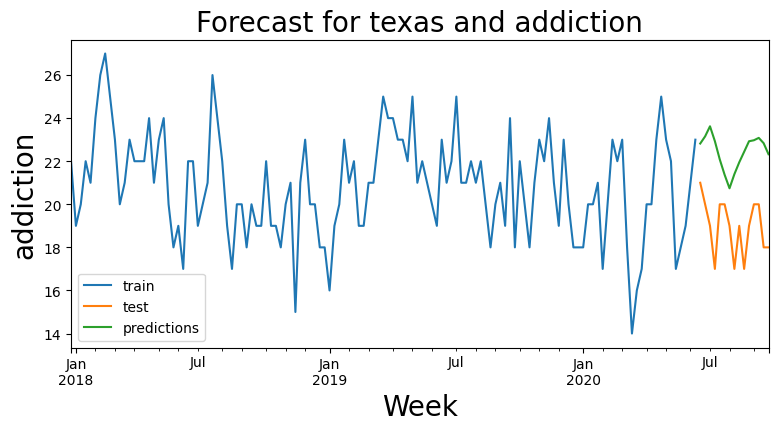

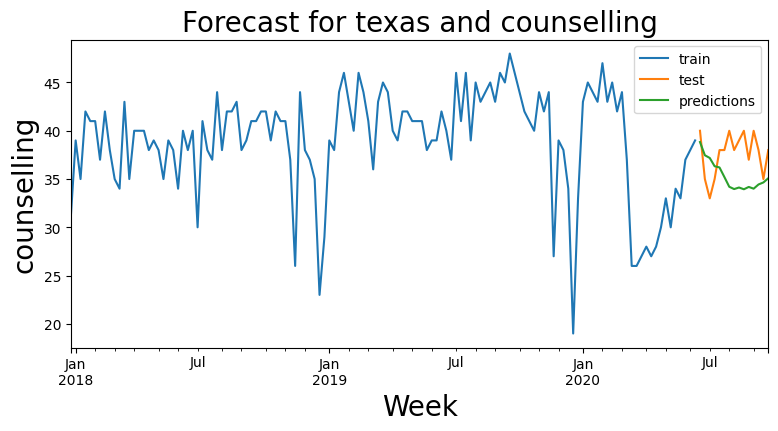

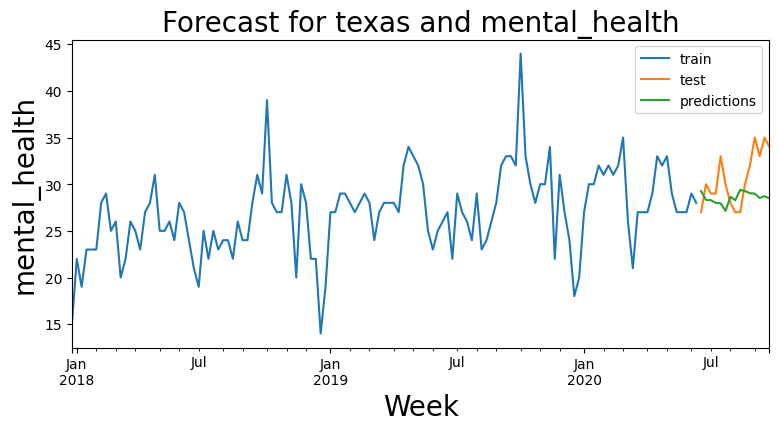

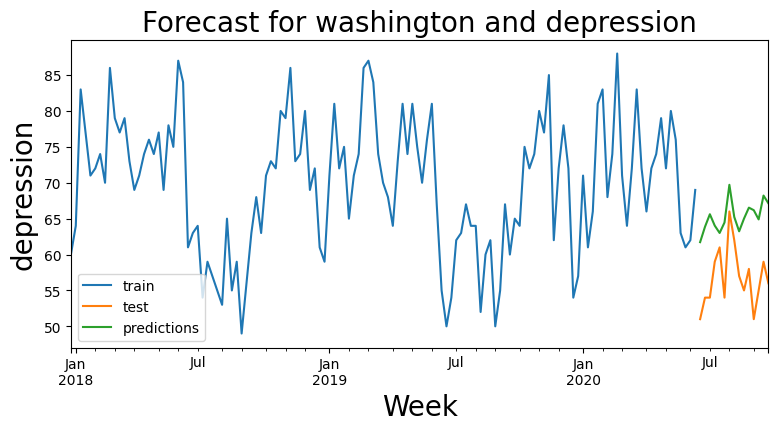

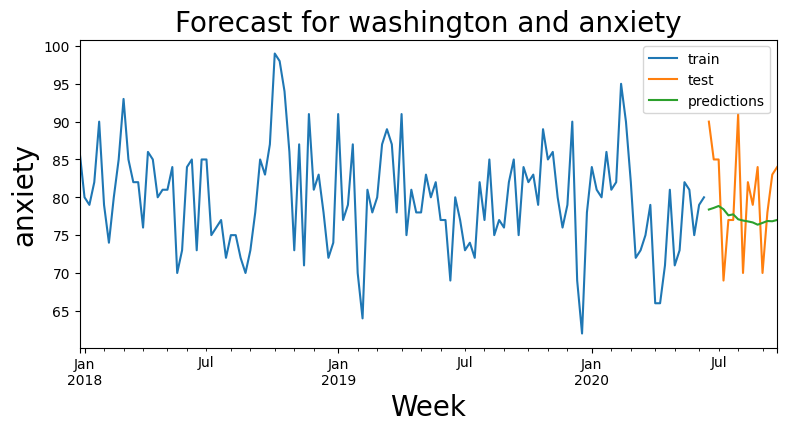

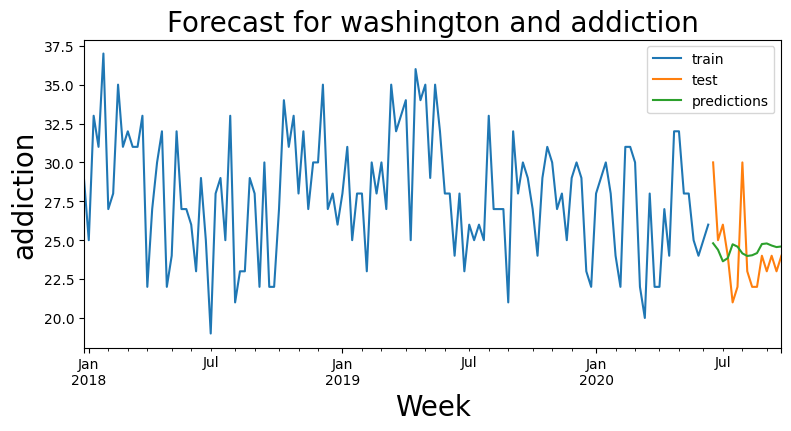

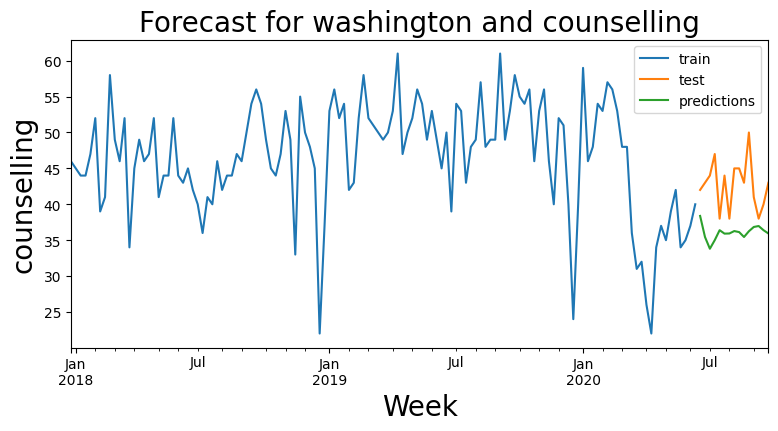

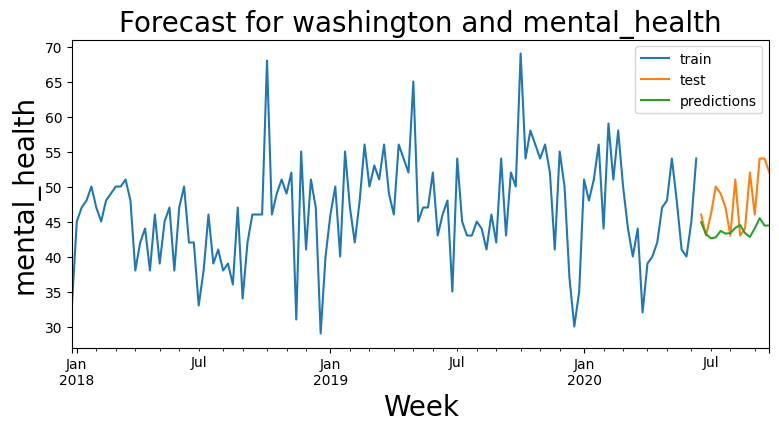

In [174]:
searches_list = ['depression', 'anxiety', 'addiction', 'counselling', 'mental_health']
states_list = ['alaska', 'arizona', 'california', 'florida', 'hawaii', 'massachussetts', 'new_york', 'south_dakota', 'texas', 'washington']

for state in states_list:
    for search in searches_list:
        forecast_state_search(state=state, period='2020-10-01', steps=15, search=search, regressor=Ridge(), lags=15)